In [1]:
#imports
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from tqdm.notebook import tqdm
import scipy.spatial.distance as spdists
from scipy.stats import ks_2samp, uniform
from scipy.interpolate import interp1d
from pyDowker.DowkerComplex import DowkerComplex
from pyDowker.TwoParameterUtils import discretize_graded_rank
import math
from joblib import Parallel, delayed
from pyrivet import rivet, hilbert_distance
import scipy.stats as st
from scipy.optimize import linear_sum_assignment
import seaborn as sns
from matplotlib.patches import Rectangle

Generate a symmetric $n\times n$ matrix $R$, whose entries below the diagonal are sampled i.i.d. from $Unif([0,1])$; the entries on the diagona are set to $\infty$ and the entries above the diagonal are by symmetry.
Now for some $p\in[0,1]$ we can threshold $R$ to obtain $A$ with $A_{i,j} = \begin{cases}1 & if\; R_{ij}\leq p\\0&if\; R_{ij}>p\end{cases}$.
This $A$ is an adjacency matrix of a $G(n,p)$-Erdös-Renyi graph.

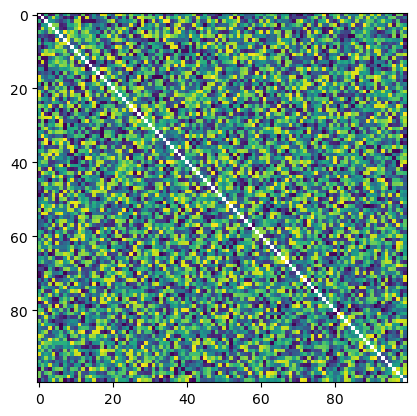

In [2]:
n = 100 #number of vertices
m = 8 # maximal number of neighbors to consider

R=uniform().rvs(size=(n,n),random_state=42)
for i in range(n):
    R[i,i] = np.inf
    for j in range(i):
        R[j,i] = R[i,j]#symmetrize
plt.imshow(R)

We can consider a filtration of Erös-Renyi graphs by varying $p$, and take the $m$-neighbor complex of each. Combined, we obtain a bifiltration of simplicial complexes. We use RIVET to compute its homology.

In [3]:
mnc = DowkerComplex(R)
l = 1 #dimension of homology
bifi = mnc.create_rivet_bifiltration(max_dimension=l+1, m_max=m)#construct bifiltration
betti = rivet.betti(bifi, homology=l, x=n,y=m) #compute homology

Now we can plot the dimensions of the homology for different $m$ as a function of $p$.
In https://arxiv.org/pdf/2302.09017.pdf, ranges for $p$ in which the homology is a.a.s. (non)-vanishing are presented, we show them as well.

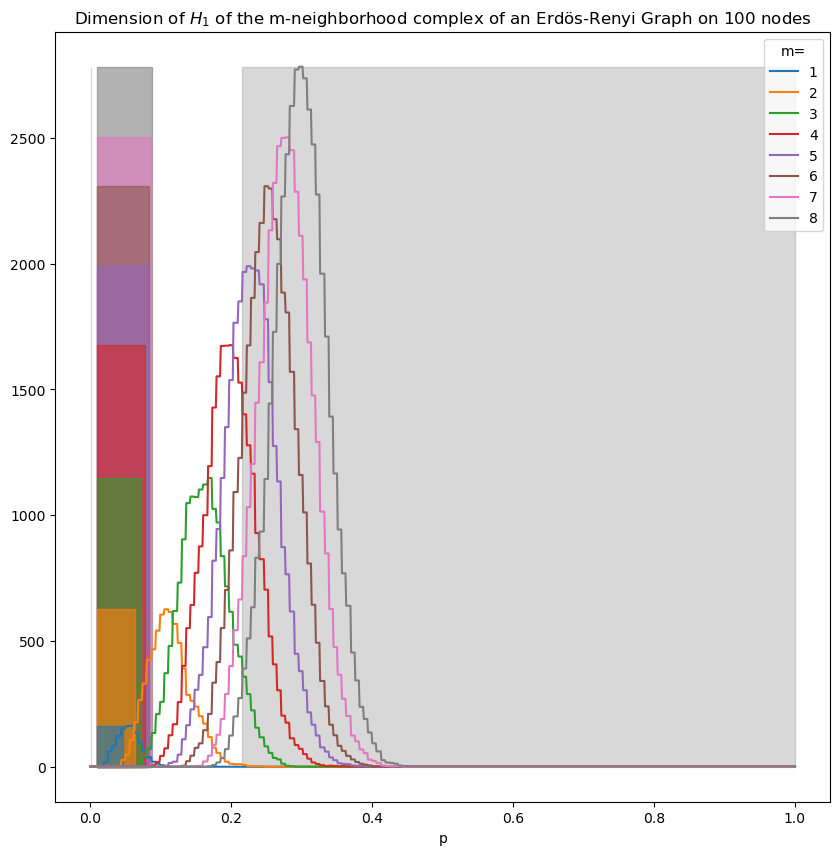

In [4]:
probs = np.linspace(0,1,1001)
A = discretize_graded_rank(betti, x_grid = probs, y_grid=np.linspace(-m,-1,m)).T[:,::-1]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown' , 'tab:pink', 'tab:gray', 'tab:olive']

f,ax = plt.subplots(1,1, figsize = (10,10))


if l%2 == 0:
    width = n**(-4/(l+2))-n**(-2)
else:
    width = n**(-4*(l+2)/((l+1)*(l+3)))-n**(-2)
vanishing_low = Rectangle((n**(-2),0), width, height = np.max(A), color = 'gray', alpha = 0.3)
vanishing_high = Rectangle((n**(-1/(l+2)),0), width=1-n**(-1/(l+2)), height = np.max(A), color = 'gray', alpha = 0.3)

for m_i in np.arange(1,m+1)[::-1]:
    nonvanishing = Rectangle((n**(-2/(l+1)),0), width=n**((-2*(m_i+1))/((2*m_i+1)*(l+1)))-n**(-2/(l+1)), height = np.max(A[:,m_i-1]), color = colors[m_i-1], alpha=0.6)
    ax.add_patch(nonvanishing)

ax.add_patch(vanishing_low)
ax.add_patch(vanishing_high)
                          
#ax[0].imshow(A)
ax.plot(probs, A, label = range(1,m+1))
ax.legend(title = 'm=')
ax.set_xlabel('p')
ax.set_title('Dimension of $H_{{{}}}$ of the m-neighborhood complex of an Erdös-Renyi Graph on {} nodes'.format(l, n))
plt.show()

For $p$ in the gray regions, the homology will a.a.s. vanish.
For $p$ in the colored region, the homology will a.a.s. not vanish.

We can repeat the same experiment without symmetrizing the matrix $R$.

In [5]:
n=200
R=uniform().rvs(size=(n,n),random_state=0)
mnc = DowkerComplex(R)
l = 1 #dimension of homology
bifi = mnc.create_rivet_bifiltration(max_dimension=l+1, m_max=m)#construct bifiltration
betti0 = rivet.betti(bifi, homology=0, x=n,y=m) #compute homology
betti1 = rivet.betti(bifi, homology=1, x=n,y=m) #compute homology

probs = np.linspace(0,1,1001)
A0 = discretize_graded_rank(betti0, x_grid = probs, y_grid=np.linspace(-m,-1,m)).T[:,::-1]
A1 = discretize_graded_rank(betti1, x_grid = probs, y_grid=np.linspace(-m,-1,m)).T[:,::-1]

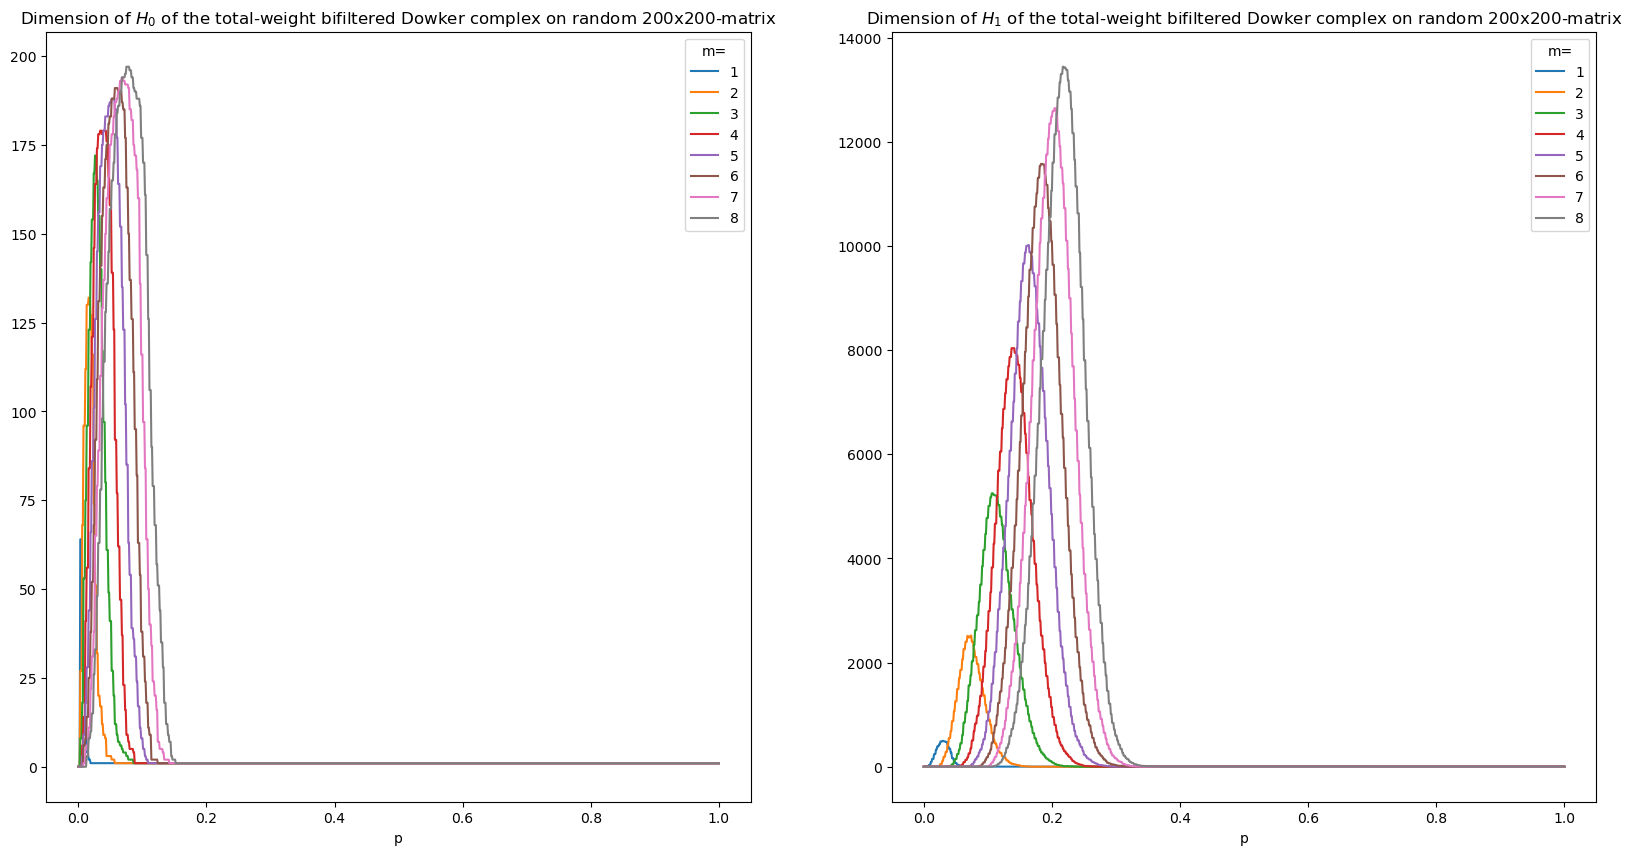

In [7]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown' , 'tab:pink', 'tab:gray', 'tab:olive']

f,ax = plt.subplots(1,2, figsize = (20,10))

ax[0].plot(probs, A0, label = range(1,m+1))
ax[0].legend(title = 'm=')
ax[0].set_xlabel('p')
ax[0].set_title('Dimension of $H_{{{0}}}$ of the total-weight bifiltered Dowker complex on random {1}x{1}-matrix'.format(0, n))
                          
#ax[0].imshow(A)
ax[1].plot(probs, A1, label = range(1,m+1))
ax[1].legend(title = 'm=')
ax[1].set_xlabel('p')
ax[1].set_title('Dimension of $H_{{{0}}}$ of the total-weight bifiltered Dowker complex on random {1}x{1}-matrix'.format(1, n))
plt.savefig('output/RandomMatrixHilbertFunction_n={}.pdf'.format(n))
plt.show()